In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

In [2]:
# sammypath = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy'
sammypath = '/Users/colefritsch/GitLab/SAMMY/sammy/build/bin/sammy'

In [3]:
%matplotlib widget

# ATARI Sammy Interface

This user example details basic use of the ATARI/SAMMY interface module. 
The example given here shows how to do individual sammy runs using the NV or IQ solution scheme.
The AutoFit example will detail sammy interface with YW scheme that can be used for automatic evaluations or simultaneous data fitting.

In [4]:
### setup the reaction model and sample a resonance
Ta_pair = Particle_Pair()      

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D=8.79,
                       gn2_avg=465,
                       gn2_dof=1,
                       gg2_avg=350,
                       gg2_dof=1000)

# setup experimental transmission model
exp_model_T = Experimental_Model()


# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions(sammypath,
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template(
    'template_T.inp', Ta_pair, exp_model_T, rto)
exp_model_T.template = os.path.realpath('template_T.inp')



In [5]:
### Generate syndat from measurement models
from ATARI.ModelData.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.syndat.control import Syndat_Model, syndatOPT


generative = Transmission_RPI()
reductive = Transmission_RPI()

synOPT = syndatOPT(calculate_covariance=True, explicit_covariance=True)

synT = Syndat_Model(
              exp_model_T,
              generative,
              reductive,
              synOPT)
## need to test syndat covariance generation with different tof ordering !!!

synT.sample(Ta_pair, 
            sammyRTO=rto,
            num_samples=1)

In [6]:
vars(generative.model_parameters)

{'trigo': (9758727, 0),
 'trigs': (18476117, 0),
 'm1': (1, 0.016),
 'm2': (1, 0.008),
 'm3': (1, 0.018),
 'm4': (1, 0.005),
 'ks': (0.563, 0.02402339737495515),
 'ko': (1.471, 0.05576763648617445),
 'b0s': (9.9, 0.1),
 'b0o': (13.4, 0.7),
 'a_b': ([582.7768594580712, 0.05149689096209191],
  [[1143.95753, 0.142659922], [0.142659922, 2.19135003e-05]]),
 'open_neutron_spectrum':                tof            bw     c         dc           E
 0    183110.960936  9.999999e-08  1180  34.351128  200.200037
 1    183010.960948  9.999998e-08  1202  34.669872  200.422933
 2    182910.960963  1.000001e-07  1173  34.249088  200.646202
 3    182810.960863  9.999996e-08  1190  34.496377  200.869845
 4    182710.960904  1.000001e-07  1206  34.727511  201.093861
 ..             ...           ...   ...        ...         ...
 184  164710.960895  9.999999e-08  1215  34.856850  248.453308
 185  164610.960907  9.999995e-08  1271  35.651087  248.761496
 186  164510.960956  1.000000e-07  1252  35.383612  24

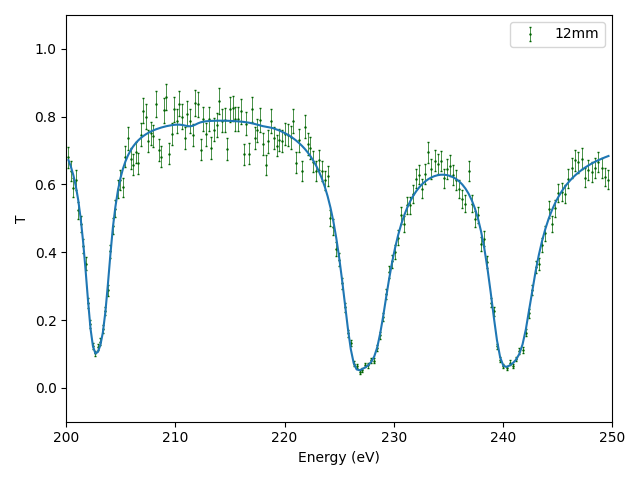

In [7]:
datasample = synT.samples[0]
data = datasample.pw_reduced


figure()
errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='darkgreen', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')
plot(data.E, data.true)
ylabel("T")

xlim([200,250])
ylim([-0.1,1.1])
legend()
xlabel('Energy (eV)')
tight_layout()

In [8]:
### Option to read in idc or you can just pass to sammy a filepath


# def read_idc(filepath):
#     data = {
#         'J': {},
#         'C': None,
#         'stat': None
#     }

#     with open(filepath, 'r') as f:
#         num_params = None
#         in_partial_derivatives = False
#         in_uncertainties = False
#         in_correlations = False
#         for line in f.readlines():
            
#             if line.lower().startswith("nu"):
#                 num_params = int(line.split()[-1])
            
#             elif line.lower().startswith("free-forma"):
#                 in_partial_derivatives = True

#             elif line.lower().startswith("uncertaint"):
#                 in_partial_derivatives = False
#                 in_uncertainties = True
            
#             elif line.lower().startswith("correlatio"):
#                 in_uncertainties = False
#                 in_correlations = True

#             elif in_partial_derivatives:
#                 splitline = line.split()
#                 E = float(splitline[0])
#                 stat_unc = float(splitline[1])
#                 derivatives = [float(x) for x in splitline[2:]]
#                 data['J'][E] = {'stat_unc': stat_unc, 'derivatives': derivatives}
                
#             elif in_uncertainties:
#                 uncertainties = [float(e) for e in line.split()]
#                 data['C'] = np.diag(uncertainties)

#             elif in_correlations:
#                 assert isinstance(num_params, int)
#                 correlations = []
#                 for _ in range(num_params):
#                     line = f.readline().strip().split()
#                     correlations.append([float(x) for x in line])

#     data['stat'] = None  # You need to fill in the logic for reading the 'stat' data

#     return data

# Usage
# filepath = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-1mm.idc'
# read_data = read_idc(filepath)

In [9]:
print(datasample.covariance_data.keys())

dict_keys(['CovT', 'Cov_sys', 'Jac_sys', 'diag_stat'])


In [10]:
datasample.covariance_data['CovT']

E,200.200037,200.422933,200.646202,200.869845,201.093861,201.318253,201.543020,201.768164,201.993685,202.219584,...,246.920925,247.226266,247.532173,247.838648,248.145693,248.453308,248.761496,249.070258,249.379595,249.689508
200.200037,0.001012,0.000259,0.000239,0.000248,0.000212,0.000196,0.000170,0.000149,0.000102,0.000077,...,0.000269,0.000273,0.000251,0.000259,0.000258,0.000262,0.000269,0.000262,0.000251,0.000248
200.422933,0.000259,0.000891,0.000225,0.000234,0.000200,0.000184,0.000160,0.000140,0.000097,0.000073,...,0.000253,0.000257,0.000236,0.000244,0.000243,0.000247,0.000253,0.000247,0.000237,0.000234
200.646202,0.000239,0.000225,0.000772,0.000215,0.000184,0.000170,0.000148,0.000129,0.000089,0.000067,...,0.000233,0.000237,0.000218,0.000225,0.000224,0.000227,0.000233,0.000228,0.000218,0.000215
200.869845,0.000248,0.000234,0.000215,0.000841,0.000191,0.000176,0.000153,0.000134,0.000092,0.000069,...,0.000242,0.000246,0.000226,0.000234,0.000232,0.000236,0.000242,0.000236,0.000227,0.000224
201.093861,0.000212,0.000200,0.000184,0.000191,0.000617,0.000151,0.000131,0.000115,0.000079,0.000059,...,0.000207,0.000210,0.000193,0.000200,0.000198,0.000202,0.000207,0.000202,0.000194,0.000191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248.453308,0.000262,0.000247,0.000227,0.000236,0.000202,0.000186,0.000162,0.000142,0.000098,0.000073,...,0.000256,0.000260,0.000239,0.000247,0.000245,0.000878,0.000256,0.000249,0.000239,0.000236
248.761496,0.000269,0.000253,0.000233,0.000242,0.000207,0.000191,0.000166,0.000145,0.000100,0.000075,...,0.000262,0.000267,0.000245,0.000253,0.000252,0.000256,0.000888,0.000256,0.000245,0.000242
249.070258,0.000262,0.000247,0.000228,0.000236,0.000202,0.000186,0.000162,0.000142,0.000098,0.000073,...,0.000256,0.000260,0.000239,0.000247,0.000245,0.000249,0.000256,0.000836,0.000239,0.000236
249.379595,0.000251,0.000237,0.000218,0.000227,0.000194,0.000179,0.000155,0.000136,0.000094,0.000070,...,0.000245,0.000250,0.000229,0.000237,0.000235,0.000239,0.000245,0.000239,0.000757,0.000227


In [11]:
# ### decomposed covariance test
# stat = copy(datasample.covariance_data["diag_stat"])
# CT = copy(datasample.covariance_data['CovT'])
# J = copy(datasample.covariance_data['Jac_sys'])
# C = copy(datasample.covariance_data['Cov_sys'])
# # C = np.diag(np.diag(C))
# test = J.T@C@J
# test.index.name = None
# assert(np.max(abs((np.diag(stat.var_stat) + test) - CT)) == 0.0)

# Fit the data with sammy

In [12]:
rto.bayes=True
rto.get_ECSCM = True
rto.ECSCM_rxn = 'transmission'

sammyINP = sammy_classes.SammyInputData(
    Ta_pair,
    Ta_pair.resonance_ladder,
    os.path.realpath('template_T.inp'),
    exp_model_T,
    # energy_grid=exp_model_T.energy_grid
    experimental_data=data,
    experimental_covariance = datasample.covariance_data
)

sammyINP.initial_parameter_uncertainty=10

# std = 0.01
# data.exp = np.random.default_rng().normal(data.true, std)
# data.exp_unc = std

sammyINP.experimental_data = data
sammyINP.resonance_ladder["varyE"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGg"] = np.ones(len(Ta_pair.resonance_ladder))
sammyINP.resonance_ladder["varyGn1"] = np.ones(len(Ta_pair.resonance_ladder))

sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
print(sammyOUT2.chi2_post)
print(sammyOUT2.chi2n_post)

1687.65
8.92936


BACKGround functions
EXPON 0 0 582.77685 33.822441 0.0514968 0.0046811 

NORMALIZATION AND BACKGROUND ARE NEXT
1.0000000        0.0                                         3
0.0384200

!! when fitting background or normalization, the output lst has an additional column I need to be robust to.

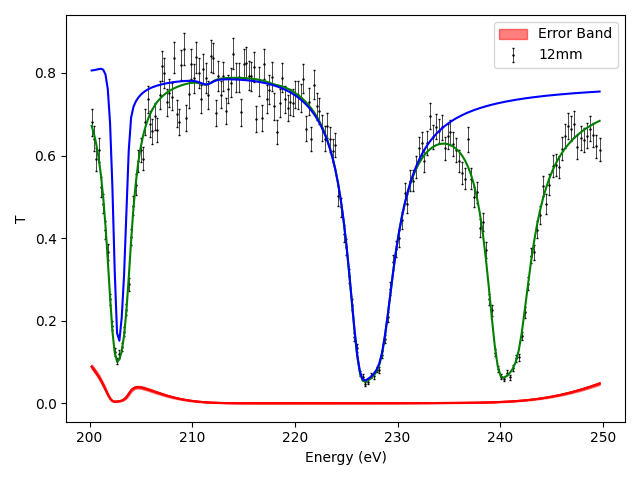

In [13]:

### Plot 
figure()

errorbar(data.E, data.exp, yerr=data.exp_unc, zorder=0,
                                        fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

plot(data.E, data.true, 'g')

plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_trans, 'b')
plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_trans_bayes, 'r')

# plot(sammyOUT2.pw.E, sammyOUT2.pw.theo_xs, 'b')
# plot(sammyOUT2.pw_post.E, sammyOUT2.pw_post.theo_xs_bayes, 'r')
# # plot(sammyOUT_old.est_df.E, sammyOUT_old.est_df.theo, 'b')
# # sammyOUT_old = copy(sammyOUT2)

x = sammyOUT2.est_df.E
y = sammyOUT2.est_df.theo
y_err=  sammyOUT2.est_df.theo_unc #
# y_err = np.sqrt(np.diag(sammyOUT2.ECSCM))
fill_between(x, y - y_err, y + y_err, color='r', alpha=0.5, label='Error Band')
plot(x, y, 'r')

ylabel("T")

# xlim([200,225])
# ylim([-0.1,1.1])
legend()

xlabel('Energy (eV)')
tight_layout()


# figure()
# imshow(sammyOUT2.ECSCM)
# colorbar()

In [14]:
ladder = copy(sammyOUT2.par_post)
print(ladder)
Ta_pair.spin_groups

            E            Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0  202.742173      0.000010   106.46388    1.0     1.0      1.0   1.0
1  211.329394    692.870744     0.06178    1.0     1.0      1.0   1.0
2  217.899467    684.340538     0.00001    1.0     1.0      1.0   1.0
3  225.639752 -10025.203000  1545.89657    1.0     1.0      1.0   1.0
4  240.661298    722.648013     0.00001    1.0     1.0      1.0   1.0


{3.0: {'Jpi': 3.0,
  'J_ID': 1,
  '<D>': 8.79,
  '<gn2>': 465,
  'n_dof': 1,
  '<gg2>': 350,
  'g_dof': 1000,
  'quantiles': {'D01': 0.9943384234177864,
   'D99': 21.284662911191237,
   'gn01': 0.07304585392801136,
   'gn99': 3085.2269194748646,
   'gg01': 314.61935642536463,
   'gg99': 387.43914802327606,
   'gt01': 314.69240227929265,
   'gt99': 3472.666067498141},
  'chs': 1,
  'Ls': [0]}}

In [15]:
from ATARI.utils.atario import expand_sammy_ladder_2_atari

expand_sammy_ladder_2_atari(Ta_pair, ladder)
ladder

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID,gg2,gn2,Jpi,L
0,202.742173,0.000010,106.46388,1.0,1.0,1.0,1.0,0.000005,2105.678810,3.0,0.0
1,211.329394,692.870744,0.06178,1.0,1.0,1.0,1.0,346.435372,1.196821,3.0,0.0
2,217.899467,684.340538,0.00001,1.0,1.0,1.0,1.0,342.170269,0.000191,3.0,0.0
3,225.639752,-10025.203000,1545.89657,1.0,1.0,1.0,1.0,-5012.601500,28982.411037,3.0,0.0
4,240.661298,722.648013,0.00001,1.0,1.0,1.0,1.0,361.324006,0.000182,3.0,0.0


In [16]:
# samples = 100

# cov_true = np.zeros([len(sammyOUT2.pw),len(sammyOUT2.pw)])
# cov_est = np.zeros([len(sammyOUT2.est_df),len(sammyOUT2.est_df)])

# for i in range(samples):
#     # synT.run(sammyOUT.pw)
#     data.exp = np.random.default_rng().normal(synT.data.true, std)
#     data.exp_unc = std
#     sammyINP.experimental_data = synT.data
#     sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#     residual = np.atleast_2d(sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#     cov_true += residual.T@residual
#     cov_est += sammyOUT2.ECSCM
#     # true.append(cov_true)
#     # est.append(cov_est)

In [17]:
# iest = 0
# fig, axes = subplots(1,2, figsize=(10,4))
# # im1 = axes[0].imshow(np.log10(cov_true/(samples)))
# # im2 = axes[1].imshow(np.log10(cov_est/(samples-1)))
# im1 = axes[0].pcolormesh(cov_true/(samples), clim=(-1e-5, 8e-5))
# im2 = axes[1].pcolormesh(cov_est/(samples-1), clim=(-1e-5, 8e-5))
# axes[0].set_title("empirical")

# axes[1].set_title("estimated")
# # for ax in axes:
# colorbar(im1)

# colorbar(im2)

# print("Empirical Fnorm")
# print(np.linalg.norm(cov_true/(samples), ord='fro'))
# print("Estimated Fnorm")
# print(np.linalg.norm(cov_est/(samples-1), ord='fro'))

In [18]:
# ### Plot 
# figure()

# # errorbar(synT.data.E, synT.data.exp, yerr=synT.data.exp_unc, zorder=0,
# #                                         fmt='.', color='k', linewidth=0.5, markersize=1.5, capsize=1, label='12mm')

# # plot(synT.data.E, synT.data.true, 'g')
# plot(synT.data.E, np.sqrt(np.diag(cov_true/samples)), label="empirical")
# plot(x, np.sqrt(np.diag(cov_est/(samples-1))), label="mean estimated")


# xlim([200,225])
# # ylim([-0.1,1.1])
# legend()

# xlabel('Energy (eV)')
# tight_layout()

In [19]:
# # result_dict = {}
# # stds = [0.1, 0.01, 0.001, 0.0001]
# stds = [0.00001, 0.05]

# for istd in stds:
#     samples = 1000
#     cov_true = np.zeros([len(sammyOUT2.pw), len(sammyOUT2.pw)])
#     cov_est = np.zeros([len(sammyOUT2.est_df), len(sammyOUT2.est_df)])
#     for i in range(samples):
#         # synT.run(sammyOUT.pw)
#         synT.data.exp = np.random.default_rng().normal(synT.data.true, istd)
#         synT.data.exp_unc = istd
#         sammyINP.experimental_data = synT.data
#         sammyOUT2 = sammy_functions.run_sammy(sammyINP, rto)
#         residual = np.atleast_2d(
#             sammyOUT2.pw.theo_trans_bayes) - np.atleast_2d(synT.data.true)
#         cov_true += residual.T@residual
#         cov_est += sammyOUT2.ECSCM
        
#     result_dict[istd] = [cov_true, cov_est]

In [20]:
# stds = [1.0, 0.1, 0.05, 0.01, 0.001, 0.0001]
# true= []
# est = []

# for istd in stds:
#     res = result_dict[istd]
#     cov_true = res[0]
#     cov_est = res[1]
#     print(istd)
#     # print("Empirical Fnorm: ", np.linalg.norm(cov_true/(samples), ord='fro'))
#     # print("Estimated Fnorm: ", np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     # true.append(np.linalg.norm(cov_true/(samples), ord='fro'))
#     # est.append(np.linalg.norm(cov_est/(samples-1), ord='fro'))
#     print("Empirical Fnorm: ", np.sum(np.diag(cov_true)**2/(samples)))
#     print("Estimated Fnorm: ", np.sum(np.diag(cov_est)**2/(samples-1)))
#     true.append(np.sum(np.diag(cov_true)**2/(samples)))
#     est.append(np.sum(np.diag(cov_est)**2/(samples-1)))

In [21]:
# figure()
# plot(stds, true, '.', label='Empirical')
# plot(stds, est, '.r', label='Estimate')
# xscale("log")
# yscale("log")
# legend()
# # ylabel("Noise Level")
# xlabel("Noise Level")